In [43]:
import numpy as np
import math
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit
from PIL import Image

%matplotlib notebook
%matplotlib notebook

In [56]:
drift_type = 'i' # i: incremental, a: abrupt, g: gradual
chunk_size = 1000

topics = ['ARGWg-F2F5F8', 'ARGWa-F3F6F3F6', 'ARGWa-F2F5F8', 'ARGWg-F1F10', 'RBFi-slow', 'RBFi-fast', 'RTGa3', 'RTGa', 'RTGg3', 'RTGg', 'SEAg-F2F4', 'SEAa-F2F4', 'ARGWa-F1F10', 'ARGWg-F3F6F3F6']

file_path = '../../DSClassificationResults/ConceptDriftExperimentsResults/{0}/'

data_file = {
#     'ADLStream (CNN1 - 60x90)' : 'ADLStream_cnn1_60x90/data.csv',
#     'ADLStream (CNN1 - 10x90)' : 'ADLStream_cnn1_10x90/data.csv',
#     'ADLStream (CNN1 - 60x40)' : 'ADLStream_cnn1_60x40/data.csv',
#     'ADLStream (CNN1 - 10x40)' : 'ADLStream_cnn1_10x40/data.csv',
    'ADLStream (CNN2 - 60x90)' : 'ADLStream_cnn2_60x90/data.csv',
#     'ADLStream (CNN2 - 10x90)' : 'ADLStream_cnn2_10x90/data.csv',
    'ADLStream (CNN2 - 60x40)' : 'ADLStream_cnn2_60x40/data.csv',
#     'ADLStream (CNN2 - 10x40)' : 'ADLStream_cnn2_10x40/data.csv',
    'ADLStream (MLP1 - 60x90)' : 'ADLStream_mlp1_60x90/data.csv',
#     'ADLStream (MLP1 - 10x90)' : 'ADLStream_mlp1_10x90/data.csv',
    'ADLStream (MLP1 - 60x40)' : 'ADLStream_mlp1_60x40/data.csv',
#     'ADLStream (MLP1 - 10x40)' : 'ADLStream_mlp1_10x40/data.csv',
    'ADLStream (MLP2 - 60x90)' : 'ADLStream_mlp2_60x90/data.csv',
#     'ADLStream (MLP2 - 10x90)' : 'ADLStream_mlp2_10x90/data.csv',
    'ADLStream (MLP2 - 60x40)' : 'ADLStream_mlp2_60x40/data.csv',
#     'ADLStream (MLP2 - 10x40)' : 'ADLStream_mlp2_10x40/data.csv',
    'ADLStream (MLP3 - 60x90)' : 'ADLStream_mlp3_60x90/data.csv',
#     'ADLStream (MLP3 - 10x90)' : 'ADLStream_mlp3_10x90/data.csv',
    'ADLStream (MLP3 - 60x40)' : 'ADLStream_mlp3_60x40/data.csv',
#     'ADLStream (MLP3 - 10x40)' : 'ADLStream_mlp3_10x40/data.csv',
    'KUE' : 'MOA_KUE/data.csv',
#     'ARF' : 'MOA_AdaptiveRandomForest/data.csv',
#     'AC' : 'MOA_ActiveClassifier/data.csv/data.csv/data.csv',
#     'NB' : 'MOA_NaiveBayes/data.csv',
#     'SCD' : 'MOA_SingleClassifierDrift/data.csv/data.csv',
#     'MC' : 'MOA_MajorityClass/data.csv',
#     'P' : 'MOA_Perceptron/data.csv',
#     'SGD' : 'MOA_SGD/data.csv',
#     'SPEG' : 'MOA_SPegasos/data.csv',
#     'LevBag' : 'MOA_LeveragingBag/data.csv',
#     'OCBO' : 'MOA_OCBoost/data.csv',
#     'BA' : 'MOA_OzaBag/data.csv',
#     'B-ASHT' : 'MOA_OzaBagASHT/data.csv',
#     'BA-AD' : 'MOA_OzaBagAdwin/data.csv',
#     'BO' : 'MOA_OzaBoost/data.csv',
#     'BO-AD' : 'MOA_OzaBoostAdwin/data.csv',
#     'WMC' : 'MOA_WeightedMajorityAlgorithm/data.csv',
#     'DST' : 'MOA_DecisionStump/data.csv',
#     'HOT' : 'MOA_HoeffdingOptionTree/data.csv',
#     'ADHOT' : 'MOA_AdaHoeffdingOptionTree/data.csv',
#     'HT' : 'MOA_HoeffdingTree/data.csv',
#     'ASHT' : 'MOA_ASHoeffdingTree/data.csv',
#     'HAT' : 'MOA_HoeffdingAdaptiveTree/data.csv',
#     'RHT' : 'MOA_RandomHoeffdingTree/data.csv'
}

figures_path = './files/drift/kappa/'


In [3]:
def read_result_csv(classifier, filepath):
    stream = pd.read_csv(filepath + data_file[classifier], 
                         header = None if 'MOA' in data_file[classifier] else 0, 
                         engine='c')
    return stream[stream.columns[-2:]]

data = { topic : { c : read_result_csv(c, file_path.format(topic))  for c in data_file } for topic in tqdm(topics) }
data[topics[0]][list(data_file.keys())[0]].sample(7)

100%|██████████| 14/14 [14:53<00:00, 63.80s/it]


KeyError: '{'

In [16]:
def plot_classes_distribution(data_stream, w=10000):
    df_classes = pd.DataFrame()
    for c, d in data_stream.groupby('class')['class']:
        d = pd.Series([np.nan if i not in d.index else d[i] for i in data_stream.index])
        df_classes[c]=d.rolling(w, center=True).count()/w

    fig, ax = plt.subplots(figsize=(12,6))
    fig.suptitle('Classes distribution', fontsize=12)

    for c in df_classes.columns:
        ax.plot(df_classes[c][int(w/2):-int(w/2)], label='Class '+str(int(c)))
        
    ax.set_xlim(0, len(data_stream))
    ax.legend()
    fig.show()

#plot_classes_distribution(data[topics[0]][list(data_file.keys())[0]])

In [17]:
@jit(nopython=True)
def kappa(real, predicted):
    classes = np.unique(np.concatenate((real,predicted)))
    n_classes = len(classes)
    index_classes = np.full(n_classes, np.nan)
    for i,c in enumerate(classes):
        index_classes[int(c)] = i
        
    confusion_matrix = np.zeros((n_classes,n_classes))
    for i in np.arange(len(real)):
        confusion_matrix[int(index_classes[int(real[i])]), int(index_classes[int(predicted[i])])] += 1
        
    sum0 = np.sum(confusion_matrix, axis=0)
    sum1 = np.sum(confusion_matrix, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)
    
    w_mat = np.ones((n_classes, n_classes))
    for i in np.arange(n_classes):
        w_mat[i,i] = 0
    
    if np.sum(w_mat * expected) == 0:
        return 1
    k = np.sum(w_mat * confusion_matrix) / np.sum(w_mat * expected)
    
    return 1 - k

@jit
def prequential_eval_sequence_sliding(data, fading_factor=0.98, chunk_size=90, metric=kappa):
    data_clean =  data[:, -2:]
    current_metric = []
    for i in np.arange(chunk_size,data_clean.shape[0]):
        k = metric(data_clean[i-chunk_size :i,0], 
                   data_clean[i-chunk_size :i,1])
        k = k if not math.isnan(k)  else 1 
        
        if current_metric:
            k = (k + current_metric[-1]*fading_factor) / (1+fading_factor)
        current_metric.append(k)
    return current_metric[:]

@jit
def prequential_eval_sequence(data, fading_factor=0.98, chunk_size=90, metric=kappa):
    data_clean =  data[:, -2:]
    current_metric = []
    for i in range(0,data_clean.shape[0]+chunk_size, chunk_size):
        k = metric(data_clean[i:i+chunk_size,0], data_clean[i:i+chunk_size,1])
        k = 1 if math.isnan(k) else k
        if current_metric:
            k = (k + current_metric[-1]*fading_factor) / (1+fading_factor)
        current_metric.append(k)
    return current_metric[:]
    

In [57]:
def plot_drift_preq(title, data, x=None, sort=False, sort_key=np.mean, drift_type='i', drifts=[250000,500000,750000], drift_window=100000):
    fig, ax = plt.subplots(figsize=(12,6))

    text = fig.suptitle(title, fontsize=12)
    ax.set_ylabel('Kappa', fontsize='medium')
    ax.set_xlabel('Instances', fontsize='medium')
    
    if drift_type in ['g', 'a']: 
        for d in drifts:
            ax.axvline(x=d, c='r', alpha=0.5)
            if drift_type == 'g':
                ax.axvline(x=d-drift_window, c='r', alpha=0.5)
                ax.axvspan(d-drift_window, d, alpha=0.1, color='red')
    if sort:
        data_sort = {k: sort_key(data[k]) for k in data.keys() }
        data = {c:data[c] for c in sorted(data_sort, key=data_sort.get, reverse=True)}
        
    for c in data:
        k = data[c]
        if x is None or len(x)!=len(k):
            x = np.arange(0,chunk_size*len(k),chunk_size)
        ax.plot(x[:-1],  k[:-1], label=(c + " %0.1f"% (sort_key(k)*100)) )

#     ax.legend(bbox_to_anchor=(1., 1.))
    lgd = ax.legend(bbox_to_anchor=(1., 1.))
#     text = ax.text(-0.2,1.05, "Aribitrary text", transform=ax.transAxes)
    fig.savefig(figures_path + title + '.png', bbox_extra_artists=(lgd,text), bbox_inches='tight')
    return figures_path + title + '.png'

    

In [19]:

# l = len(list(data.values())[0])
data_kappa = {topic : {c : prequential_eval_sequence(data[topic][c].values[:], chunk_size=chunk_size) for c in data_file.keys()} for topic in tqdm(topics)}
# f = round(l/(len(list(data_kappa[topics[0]].values())[0])))
# x = [i*f +f for i in range(len(list(data_kappa[topics[0]][].values())[0]))]

100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


<IPython.core.display.Javascript object>


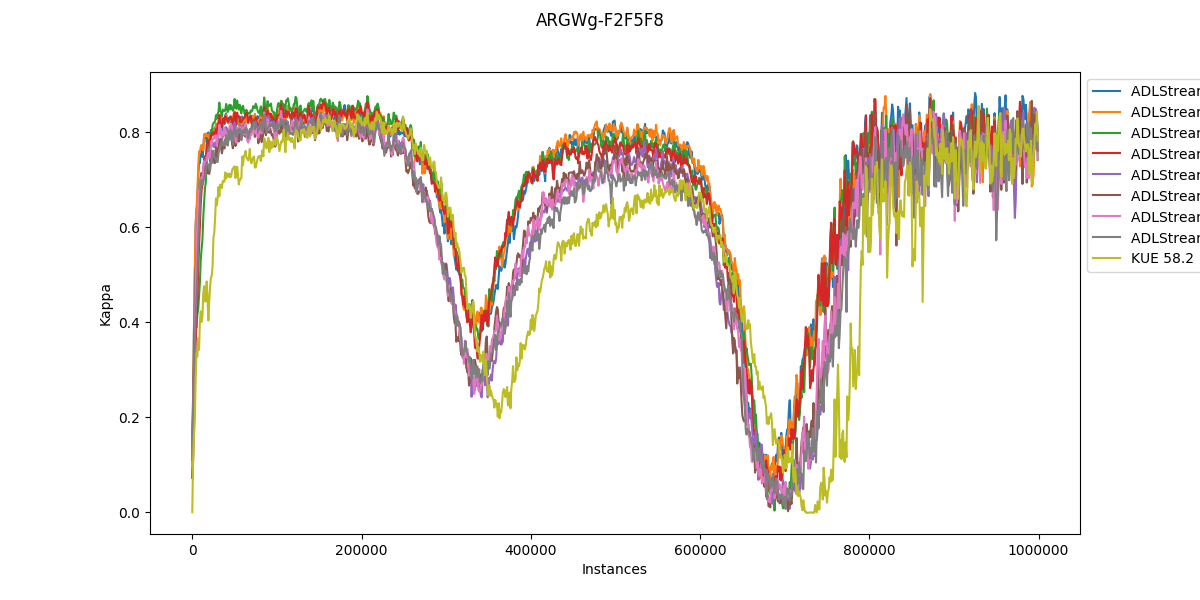

<IPython.core.display.Javascript object>


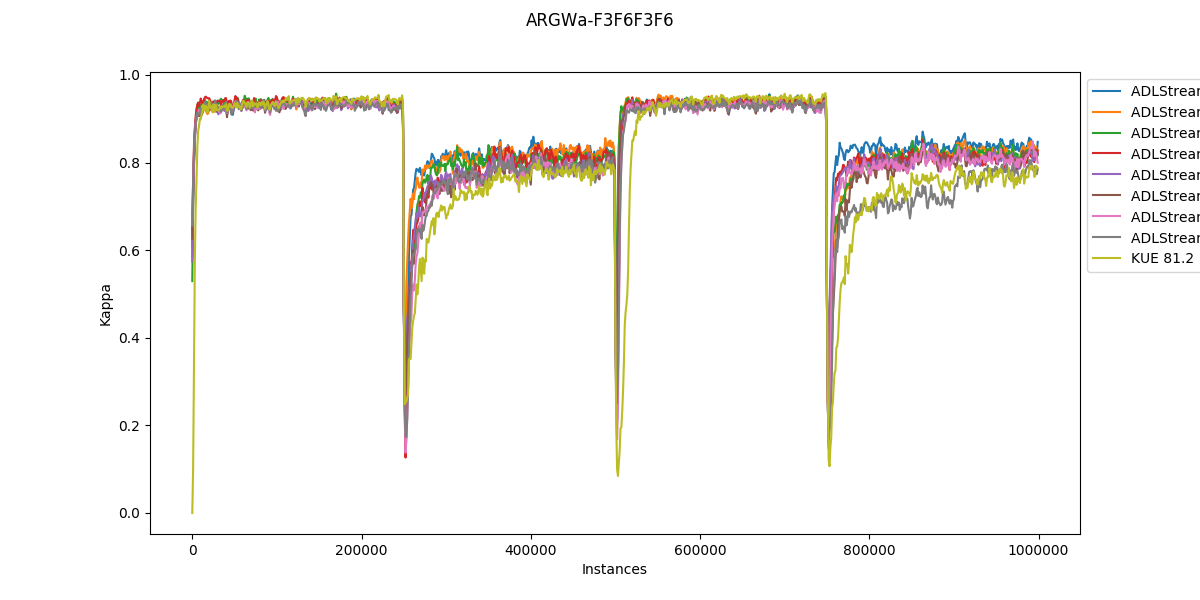

<IPython.core.display.Javascript object>


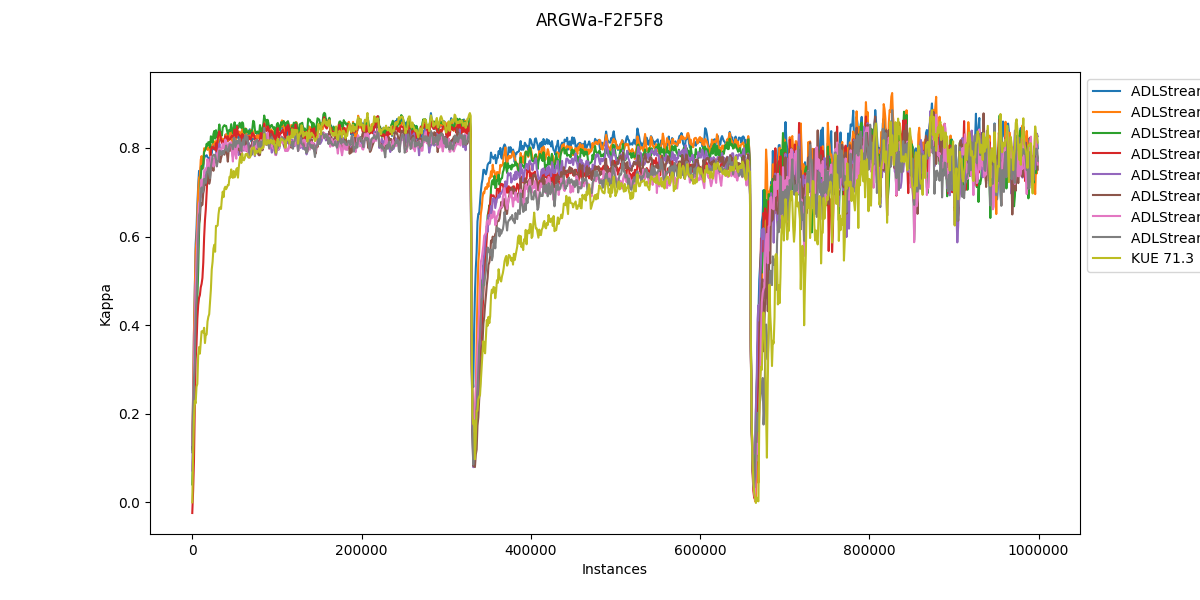

<IPython.core.display.Javascript object>


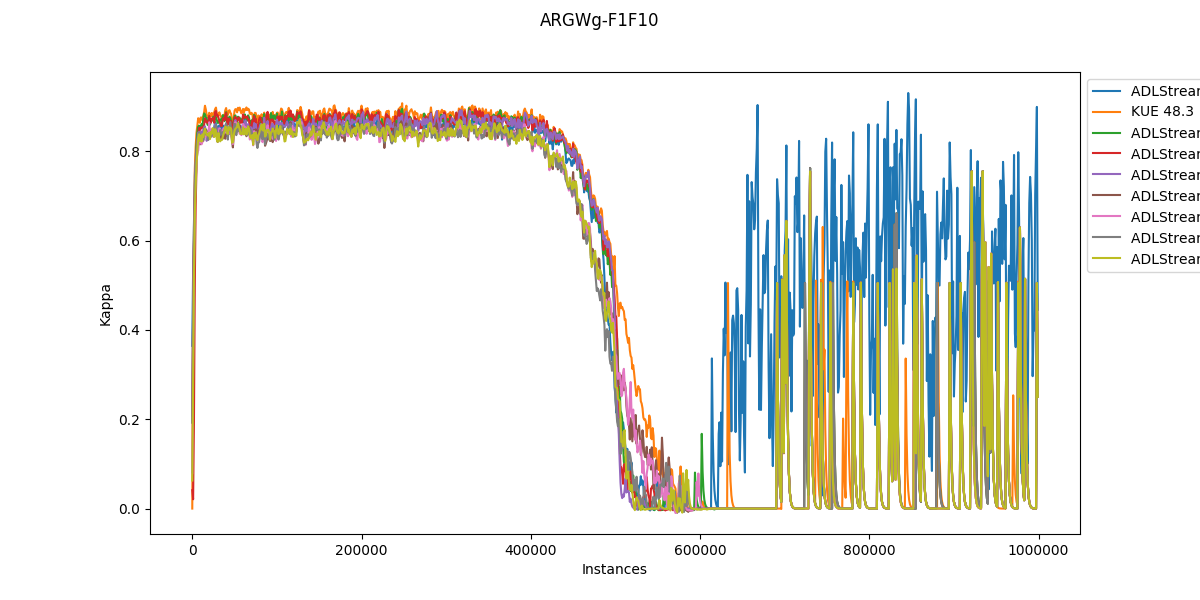

<IPython.core.display.Javascript object>


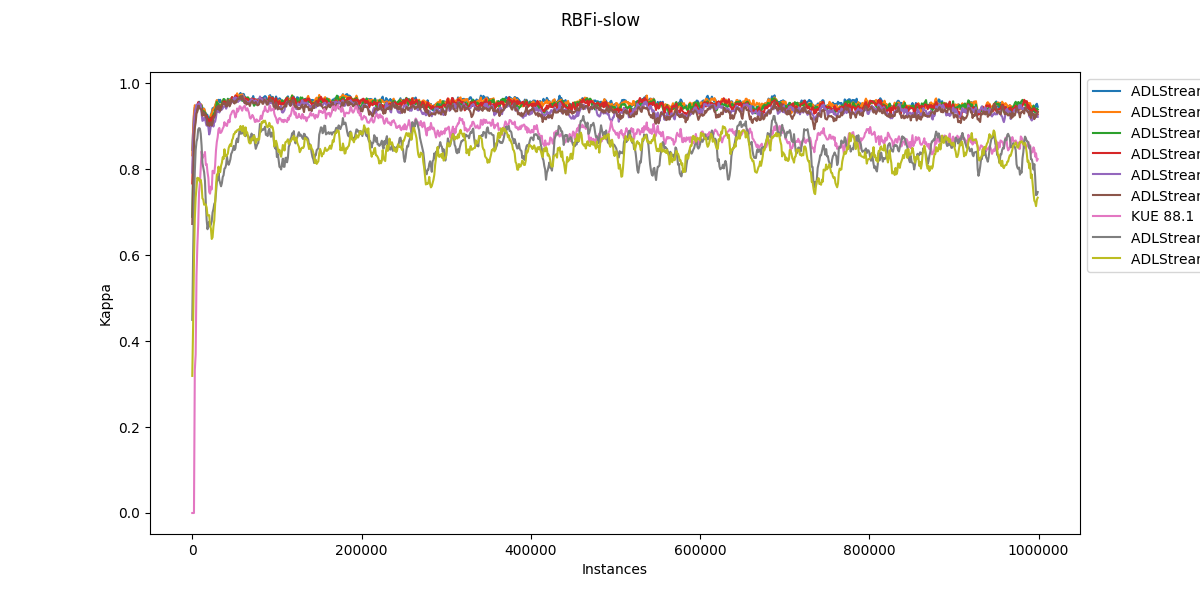

<IPython.core.display.Javascript object>


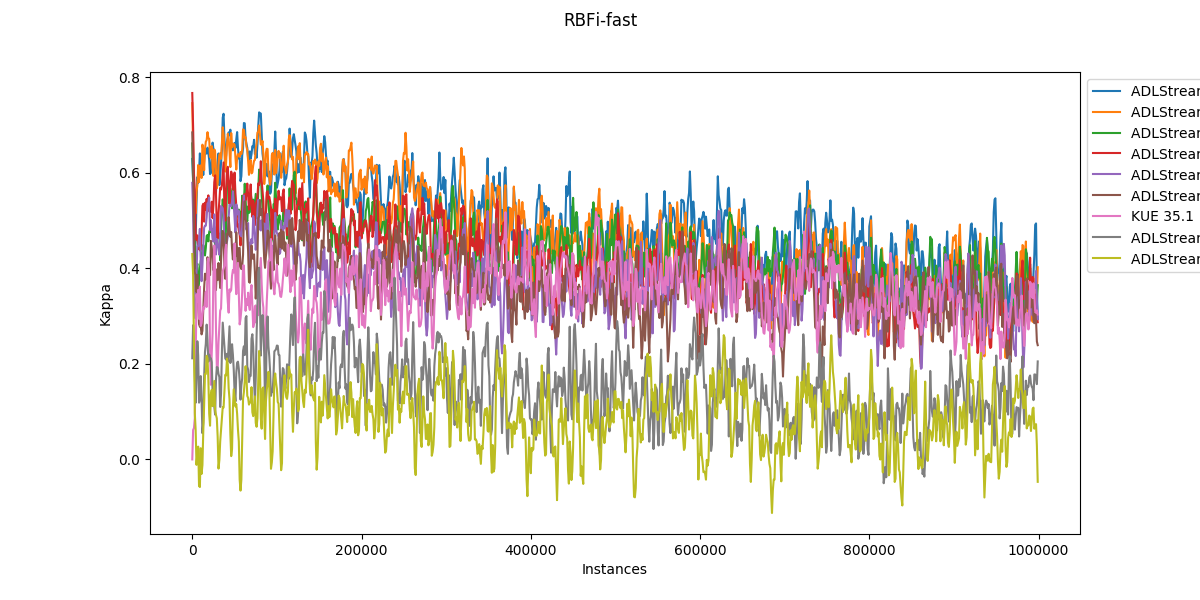

<IPython.core.display.Javascript object>


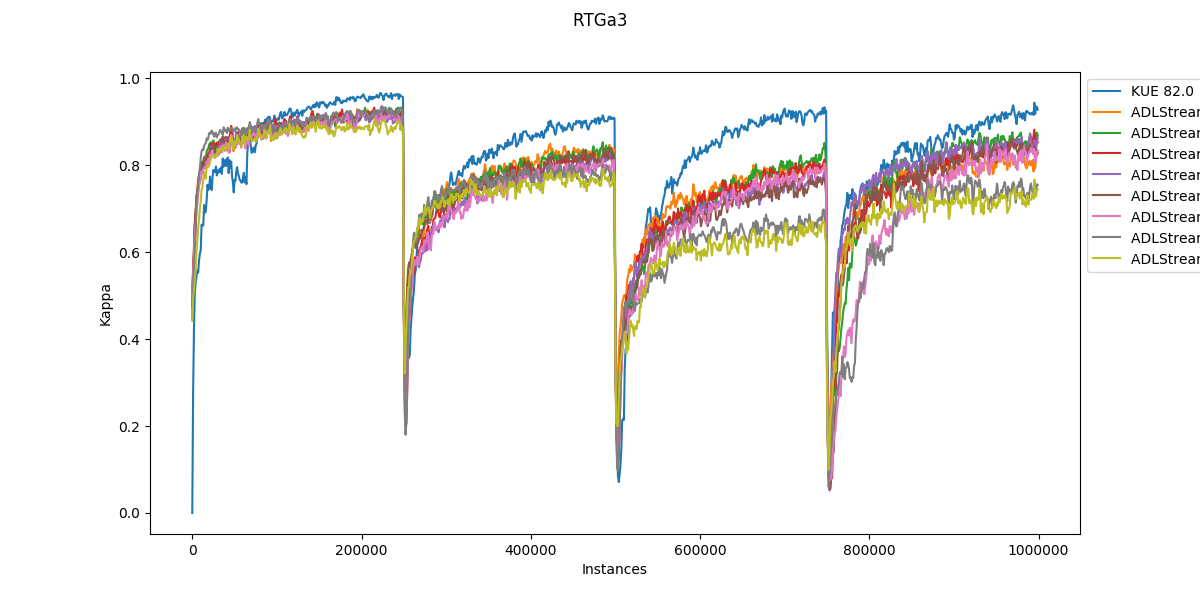

<IPython.core.display.Javascript object>


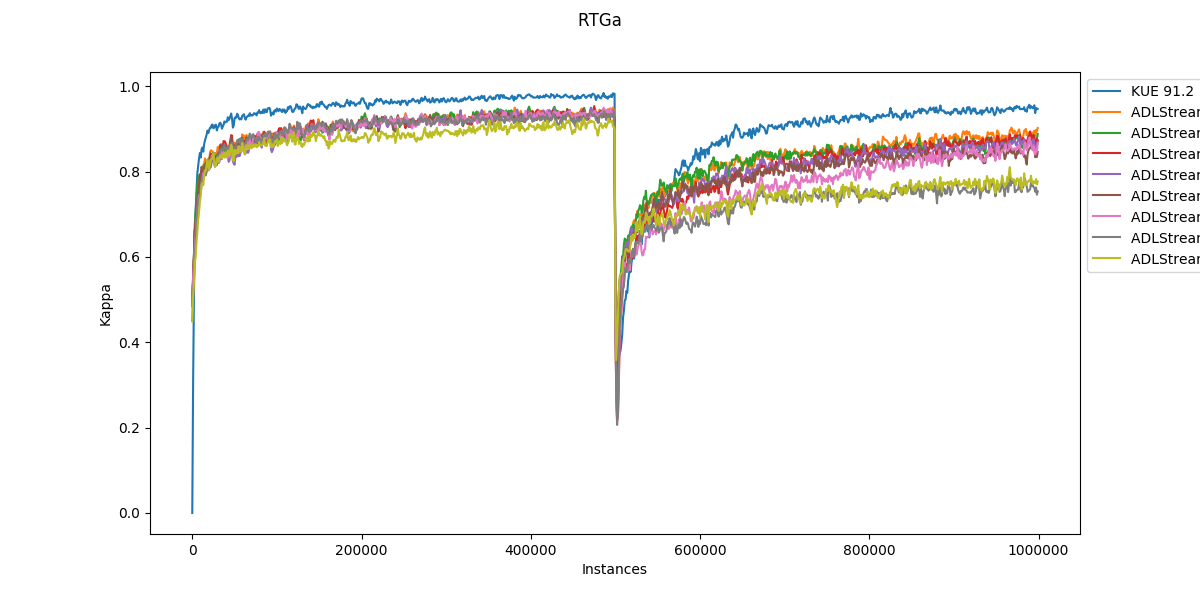

<IPython.core.display.Javascript object>


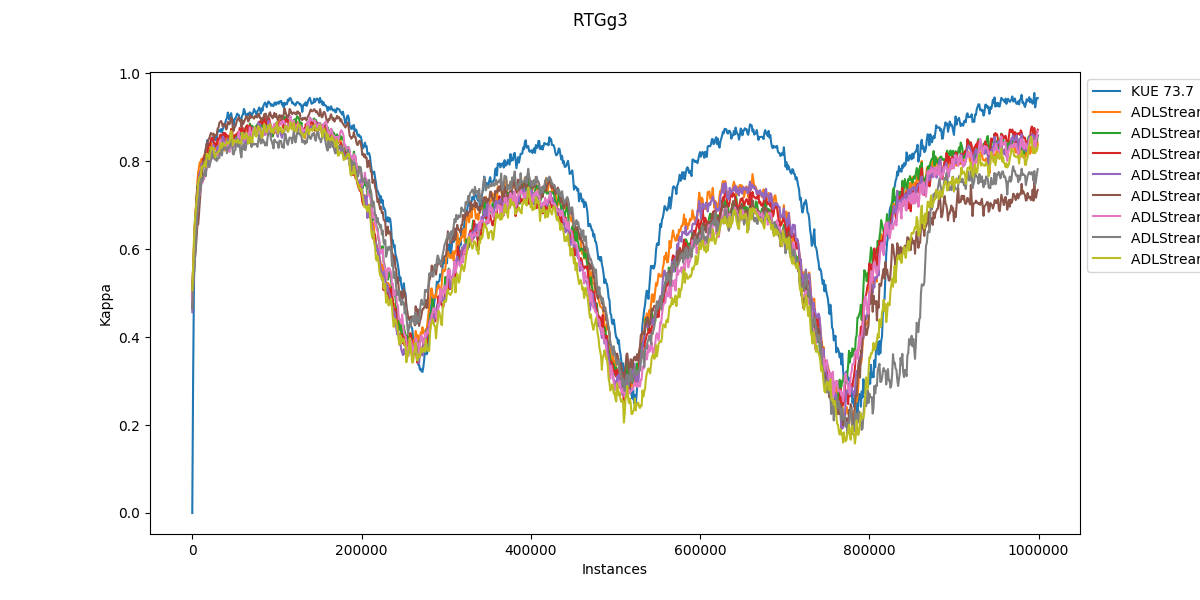

<IPython.core.display.Javascript object>


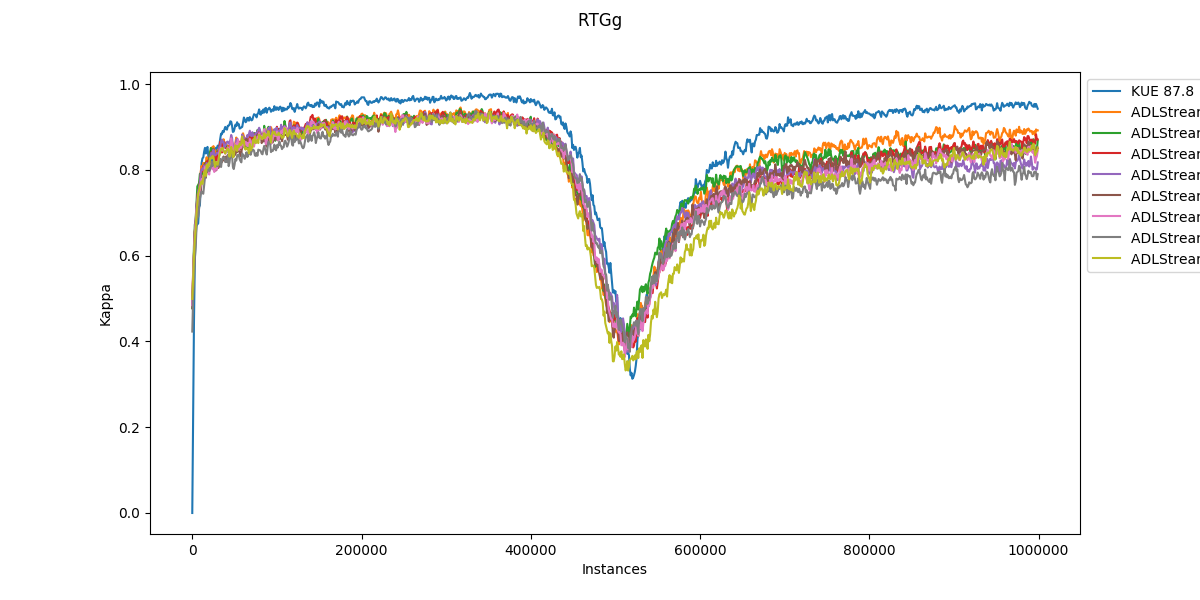

<IPython.core.display.Javascript object>


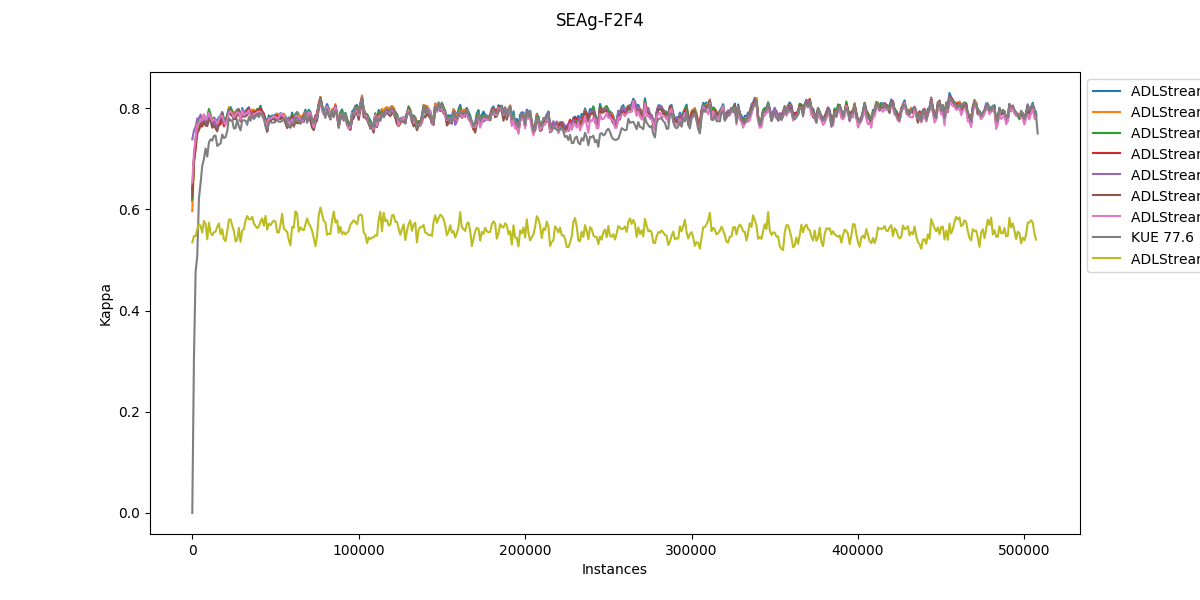

<IPython.core.display.Javascript object>


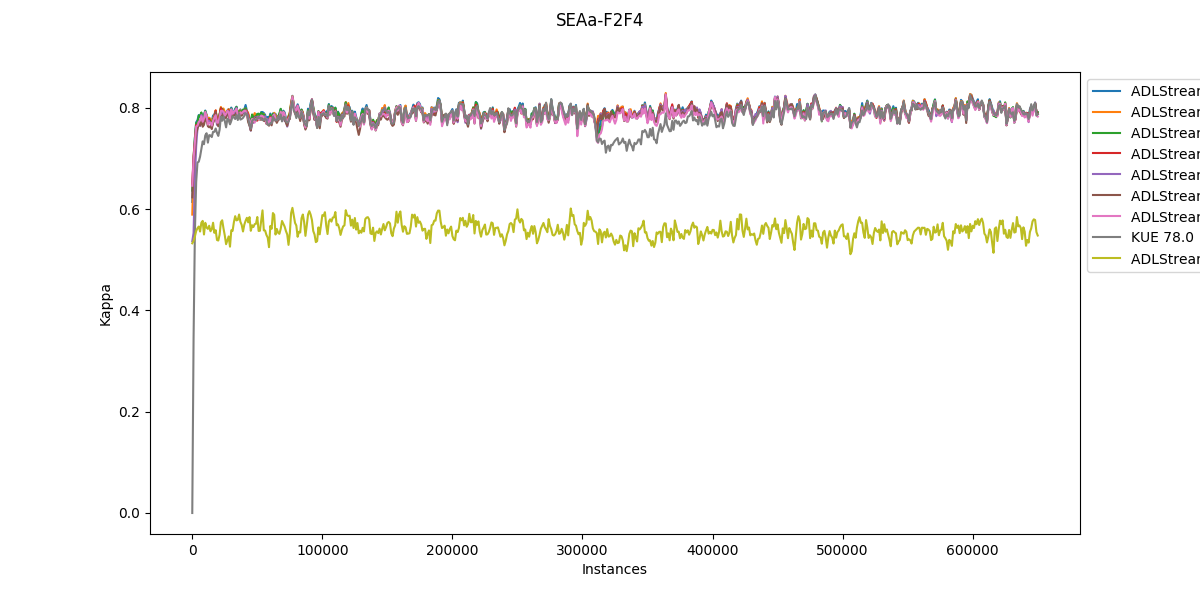

<IPython.core.display.Javascript object>


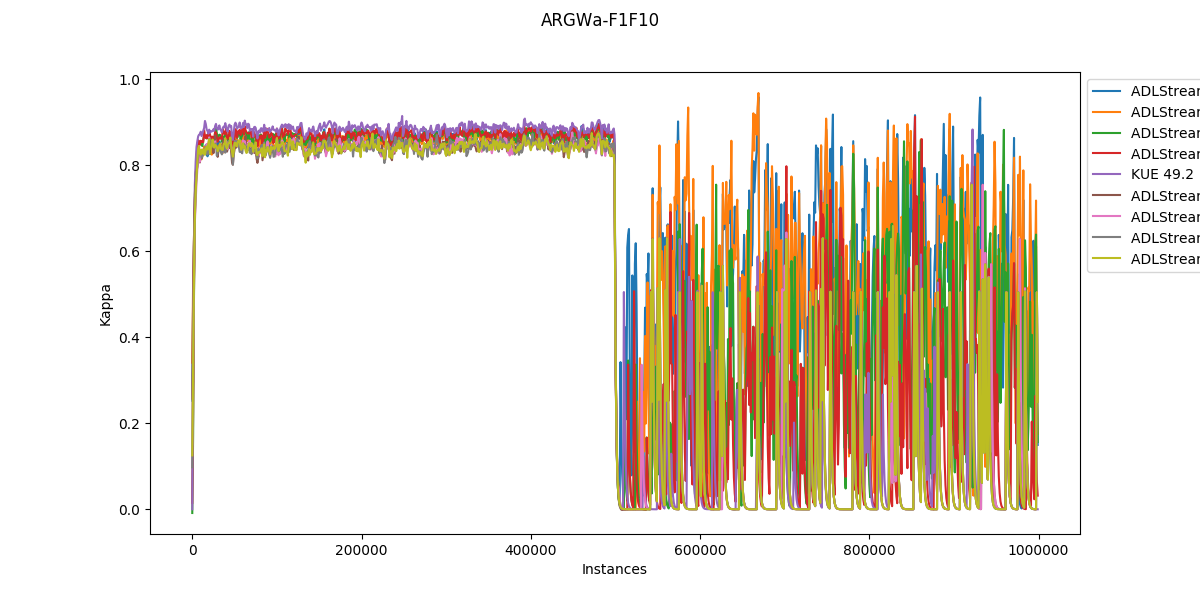

<IPython.core.display.Javascript object>


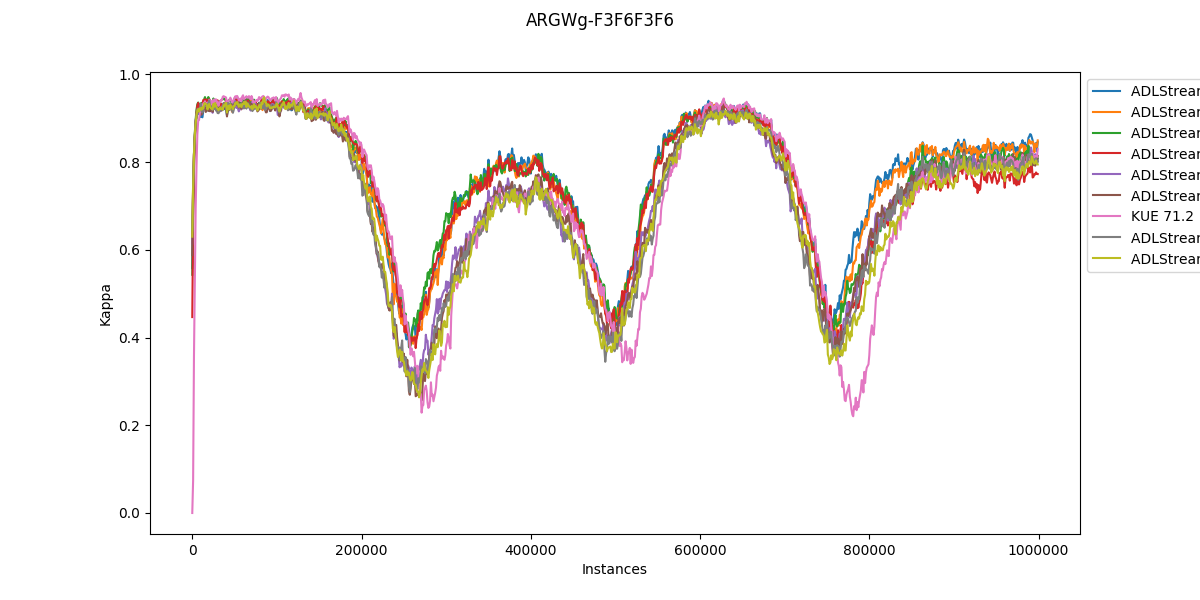

In [58]:
pdf_img_ls = []
for topic in topics:
    pdf_img_ls.append(plot_drift_preq(topic, data_kappa[topic], sort=True, sort_key=np.mean, drift_type='i'))

pdf_img_ls = [Image.open(i).convert('RGB') for i in pdf_img_ls]
pdf_filename = figures_path+'datastreams_drift_kappa.pdf'
first = pdf_img_ls[0].copy()
first.save(pdf_filename,"PDF", resolution=100.0, save_all=True, append_images=pdf_img_ls[1:])
pdf_img_ls = []

In [9]:
data_k_mean = {k: np.mean(data_k[k]) for k in data_k.keys() }
{c:data_k_mean[c] for c in sorted(data_k_mean, key=data_k_mean.get, reverse=True)}

{'ADLStream (MLP3 - 60x40)': 0.49998397086891755,
 'ADLStream (CNN2 - 60x40)': 0.474428678112918,
 'ADLStream (MLP3 - 60x90)': 0.4355475092007238,
 'ADLStream (CNN2 - 60x90)': 0.41235183269729153,
 'ADLStream (MLP1 - 60x40)': 0.3752473208557499,
 'ADLStream (MLP1 - 60x90)': 0.36307074394932043,
 'KUE': 0.3514233027295177,
 'ADLStream (MLP2 - 60x40)': 0.14972177742113066,
 'ADLStream (MLP2 - 60x90)': 0.08947028748437892}

In [10]:
data_k_mean = {k: data_k[k][-2] for k in data_k.keys() }
{c:data_k_mean[c] for c in sorted(data_k_mean, key=data_k_mean.get, reverse=True)}

{'ADLStream (CNN2 - 60x40)': 0.40239342510453585,
 'ADLStream (MLP3 - 60x90)': 0.36477435232946565,
 'KUE': 0.3034688539421333,
 'ADLStream (MLP3 - 60x40)': 0.29405182192859497,
 'ADLStream (MLP1 - 60x40)': 0.2936565040601803,
 'ADLStream (CNN2 - 60x90)': 0.2872367857847565,
 'ADLStream (MLP1 - 60x90)': 0.23917286806595384,
 'ADLStream (MLP2 - 60x40)': 0.20520504773693893,
 'ADLStream (MLP2 - 60x90)': -0.04689881897151142}